## Imports

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

## Данные

In [2]:
df = pd.read_csv('Очищенные данные.csv', sep=',', index_col=0, parse_dates=['DT'])
df.head()

,DT,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,...,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2
nplv,,,,,,,,,,,,,,,,,,,,,
г683863<887,2070-06-21 02:00:00,24.0,43.350000,17.950000,43.350000,NaN,0.331665,0.081490,0.132332,0.139860,...,0.12,2.6,0.0,NaN,57.2,0.5,8.1,0.13,2.3,NaN
г683863<888,2070-06-21 02:58:00,17.0,46.183333,19.816667,46.183333,NaN,0.377945,0.133194,0.221605,0.165186,...,0.11,2.4,0.0,NaN,60.3,0.5,6.3,0.12,2.6,NaN
г683863<978,2070-06-25 02:57:00,29.0,42.716667,16.683333,42.716667,2.623711,0.433500,0.113524,0.189868,0.133175,...,0.15,2.2,0.0,NaN,56.9,0.6,7.9,0.11,2.2,NaN
г683863<979,2070-06-25 03:59:00,20.0,42.050000,18.716667,42.050000,2.692771,0.459085,0.124202,0.218667,0.192129,...,0.39,1.8,0.0,NaN,50.9,0.3,13.2,0.13,2.0,NaN
г683863<97:,2070-06-25 04:52:00,23.0,41.666667,20.183333,41.666667,2.829225,0.454145,0.088234,0.182319,0.153034,...,0.20,2.3,0.0,NaN,49.0,1.0,12.6,0.20,2.2,NaN


In [3]:
len(df.columns)

68

## Feature Engineering

In [4]:
pearson_corr = df.drop('DT', axis=1).corr(method='pearson', min_periods=50)
pos_corr = np.abs(np.nan_to_num(pearson_corr.values, 0.0))
strong_corr_pairs = []
for i in range(1, len(pos_corr)):
    if np.max(pos_corr[i, :i]) >= 0.8:
        j = np.argmax(pos_corr[i, :i])
        strong_corr_pairs.append((i, j, pearson_corr.values[i, j]))

In [5]:
cols = df.drop('DT', axis=1).columns
cols_dict = dict(list(zip(range(len(cols)), cols)))

In [6]:
# сильно коррелирующие фичи
strong_corr_df = pd.DataFrame(strong_corr_pairs).replace(cols_dict).sort_values(2, ascending=False)
strong_corr_df

,0,1,2
5,ферспл SiMn18,чист расход Mn,0.998040
6,ферспл фх850А,чист расход Cr,0.996654
0,t продувка,t обработка,0.996427
14,химсталь последний Ni,химсталь первый Ni_1,0.992914
12,химсталь последний Cu,химсталь первый Cu_1,0.989583
3,ферспл FeV-80,чист расход V,0.982945
7,эл. энергия,t под током,0.961281
1,расход газ Ar,Ar (интенс.),0.958868
15,химсталь последний P,химсталь первый P_1,0.956263
13,химсталь последний Mo,химсталь первый Mo_1,0.956114


In [7]:
cols_for_engineering = ['химсталь последний Ni',
                        'химсталь последний Cu',
                        'химсталь последний P',
                        'химсталь последний Mo',
                        'химшлак первый SiO2_1']
corr_cols_to_drop = [col for col in strong_corr_df[0] if col not in cols_for_engineering]

In [8]:
df.drop(corr_cols_to_drop, axis=1, inplace=True)

In [9]:
pairs = strong_corr_df[strong_corr_df[0].isin(cols_for_engineering)][[0,1]].values
pairs

array([['химсталь последний Ni', 'химсталь первый Ni_1'],
       ['химсталь последний Cu', 'химсталь первый Cu_1'],
       ['химсталь последний P', 'химсталь первый P_1'],
       ['химсталь последний Mo', 'химсталь первый Mo_1'],
       ['химшлак первый SiO2_1', 'химшлак первый Al2O3_1']], dtype=object)

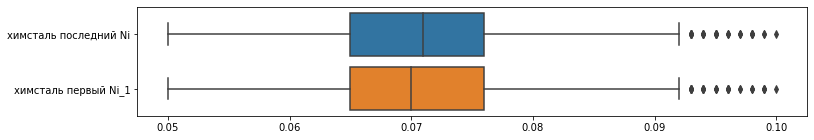

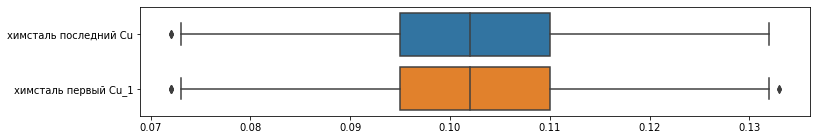

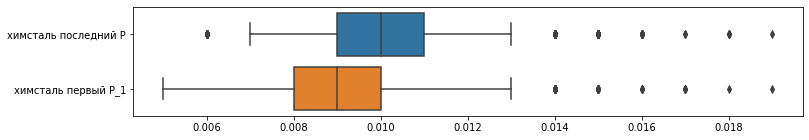

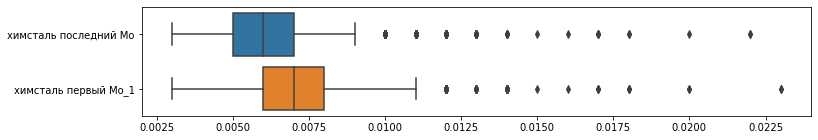

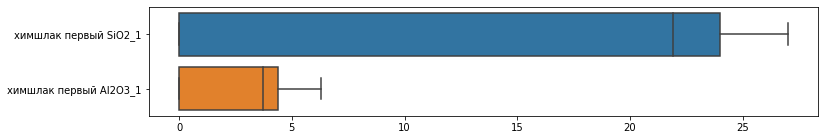

In [10]:
for pair in pairs:
    fig = plt.figure(figsize=(12, 2))
    sns.boxplot(data=df[pair], orient='h')

Колонки с Ni и Cu можно убрать.

In [11]:
df.drop(['химсталь первый Cu_1', 'химсталь первый Ni_1'], axis=1, inplace=True)

In [12]:
pairs = np.delete(pairs, 0, axis=0) # ['химсталь последний Ni', 'химсталь первый Ni_1']
pairs = np.delete(pairs, 0, axis=0) # ['химсталь последний Cu', 'химсталь первый Cu_1']

Попробуем отношение.

In [13]:
def safe_division(x, y):
    if (x != x) | (y != y) | (y == 0):
        return np.nan
    return x / y

for pair in pairs:
    new_col = pair[0]+'_'+pair[1]+'_ratio'
    df[new_col] = df.apply(lambda x: safe_division(x[pair[0]],x[pair[1]]), axis=1)

## Feature Importance

In [16]:
TARGETS = ['химшлак последний Al2O3', 'химшлак последний CaO',
           'химшлак последний R', 'химшлак последний SiO2']

In [18]:
df.drop('DT', axis=1, inplace=True) # не понадобится, скорее всего

In [19]:
for col in df.columns:
    if df[col].nunique() <= 50:
        df[col] = df[col].astype('category')

In [20]:
NUMERICAL = df.select_dtypes(exclude=['category', 'object', 'datetime64']).columns.tolist()
ORDINAL = df.select_dtypes(include=['category']).columns.tolist()
for tar in TARGETS:
    if tar in NUMERICAL:
        NUMERICAL.remove(tar)

#### Correlations

In [41]:
correlations = dict()

for tar in TARGETS:
    correlations[tar] = dict()
    for col in NUMERICAL:
        correlations[tar][col] = df[col].corr(df[tar])

In [55]:
corrs = pd.DataFrame(correlations)
corrs[(abs(corrs) > 0.3).any(1)]

,химшлак последний Al2O3,химшлак последний CaO,химшлак последний R,химшлак последний SiO2
чист расход C,0.342188,-0.168741,-0.152759,-0.028422
чист расход Mn,-0.208593,-0.161149,-0.355493,0.261351
чист расход Si,-0.279295,-0.215806,-0.406475,0.290977
химшлак первый CaO_1,0.137585,0.306580,0.353618,-0.134561
химшлак первый MgO_1,-0.194052,-0.304754,-0.386062,0.219280
химшлак первый SiO2_1,-0.281995,-0.064292,0.014975,0.324356
химшлак последний MgO,-0.249199,-0.399977,-0.512202,0.291733
химшлак первый SiO2_1_химшлак первый Al2O3_1_ratio,-0.656790,0.027156,-0.277064,0.314707


In [56]:
golden_features = list(corrs[(abs(corrs) > 0.3).any(1)].index)

#### Imputter

In [57]:
for col in NUMERICAL:
    df[col] = df[col].fillna(df[col].mean())

In [60]:
for col in ORDINAL:
    df[col] = df[col].fillna(df[col].mode())

#### Lasso

In [66]:
data = df.dropna().astype(float)
data = (data - data.mean()) / (data.std() + 0.0001)

In [70]:
x_train, x_test, y_train, y_test = train_test_split(
    data.drop(columns = TARGETS),
    data[TARGETS],
    test_size=0.3,
    shuffle = True)

In [72]:
clf = linear_model.Lasso(alpha=0.07)
clf.fit(x_train, y_train)

Lasso(alpha=0.07)

In [78]:
names = df.drop(columns = TARGETS).columns
for i,m in enumerate(clf.coef_):
    print(TARGETS[i])
    print(names[np.where(m != 0)].values)

химшлак последний Al2O3
['чист расход C' 'чист расход Mn' 'чист расход Si'
 'химшлак первый Al2O3_1' 'химшлак первый R_1' 'химшлак последний FeO'
 'химшлак последний MgO' 'химшлак последний MnO'
 'химшлак первый SiO2_1_химшлак первый Al2O3_1_ratio']
химшлак последний CaO
['чист расход C' 'химсталь последний Cu' 'химшлак первый Al2O3_1'
 'химшлак первый CaO_1' 'химшлак первый R_1' 'химшлак последний FeO'
 'химшлак последний MgO']
химшлак последний R
['чист расход Mn' 'чист расход Si' 'химшлак первый R_1'
 'химшлак последний MgO' 'химшлак последний MnO']
химшлак последний SiO2
['t под током' 'чист расход Mn' 'чист расход Si' 'химсталь первый N_1'
 'химсталь последний N' 'химшлак первый R_1' 'химшлак первый SiO2_1'
 'химшлак последний FeO' 'химшлак последний MgO' 'химшлак последний MnO'
 'химшлак первый SiO2_1_химшлак первый Al2O3_1_ratio']


#### Random Forest

In [85]:
cols = data.columns
for tar in TARGETS:
    forest = RandomForestRegressor(n_estimators=100,
                                   oob_score = True,
                                   bootstrap = True,
                                   random_state=42)
    forest.fit(data.drop(columns = TARGETS), data[tar])
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]
    print("Feature ranking for {}:".format(tar))
    for f in range(data.shape[1] - len(TARGETS)):
        print("%d.\t %s (%f)" % (f + 1, names[indices[f]], importances[indices[f]]))
    print()

Feature ranking for химшлак последний Al2O3:
1.	 химшлак первый SiO2_1_химшлак первый Al2O3_1_ratio (0.422354)
2.	 химшлак первый Al2O3_1 (0.080593)
3.	 химшлак последний MnO (0.060798)
4.	 чист расход C (0.034879)
5.	 химшлак первый MgO_1 (0.019247)
6.	 химшлак последний MgO (0.018494)
7.	 химшлак первый CaO_1 (0.016668)
8.	 чист расход Mn (0.013704)
9.	 чист расход Si (0.013336)
10.	 температура первая (0.012429)
11.	 чист расход Cr (0.012365)
12.	 t под током (0.012089)
13.	 t вып-обр (0.011810)
14.	 химшлак первый MnO_1 (0.011763)
15.	 химсталь последний Si (0.011179)
16.	 химшлак первый SiO2_1 (0.011171)
17.	 сыпуч  шпат плав. (0.011130)
18.	 чист расход V (0.011079)
19.	 химсталь последний C (0.011019)
20.	 t обработка (0.010885)
21.	 Ar (интенс.) (0.010868)
22.	 эл. энергия (интенс.) (0.010858)
23.	 произв жидкая сталь (0.010283)
24.	 химсталь последний Mn (0.010061)
25.	 химсталь последний Cu (0.009859)
26.	 температура последняя (0.009821)
27.	 химшлак последний FeO (0.009656)

## Model